In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import uncertainties

from scipy.stats import linregress, gmean
from numpy.linalg import lstsq
import statsmodels.api as sm

from matplotlib import pyplot as plt

In [2]:
abund_df = pd.read_csv('../data/Chure_mean_absolute_measurements.csv', index_col=0)
chemostat_df = pd.read_csv('../data/kayser_chemostat_growth.csv')

In [3]:
chemostat_df.head()

,D_per_h,biomass_g_l,glucose_g_l,acetate_g_l,ammonium_g_l,CTR,OTR,c_recovery_pct,n_recovery_pct,r_biomass_g_l_h,r_glucose_g_g_h,r_co2_g_g_h,r_o2_g_g_h,r_acetate_g_g_h,r_ammonium_g_g_h
0,0.044,5.07,0.0,0.0,1.709,0.286,0.222,96,99,0.223,0.087,0.056,0.0437,0.0 000,0.0060
1,0.066,5.05,0.0,0.0,1.688,0.440,0.288,97,98,0.333,0.131,0.087,0.0570,0.0 000,0.0093
2,0.134,5.29,0.0,0.0,1.652,0.924,0.576,101,98,0.709,0.253,0.175,0.1089,0.0 000,0.0190
3,0.150,5.24,0.0,0.0,1.650,0.915,0.615,95,98,0.785,0.287,0.175,0.1175,0.0 000,0.0215
4,0.170,5.23,0.0,0.0,1.656,1.113,0.896,98,98,0.889,0.325,0.213,0.1713,0.0 000,0.0242


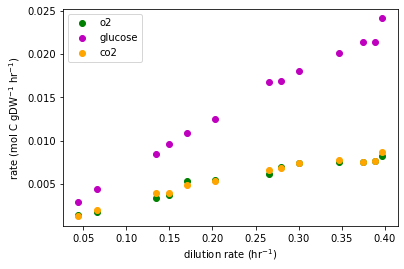

In [4]:
# load Kayser chemostat growth data - regress O2 consumption as a function of growth
plt.figure()
mw_o2 = 32
mw_co2 = 44
mw_gluc = 180
plt.scatter(chemostat_df.D_per_h, chemostat_df.r_o2_g_g_h/mw_o2, color='g', label='o2')
plt.scatter(chemostat_df.D_per_h, 6*chemostat_df.r_glucose_g_g_h/mw_gluc, color='m', label='glucose')
plt.scatter(chemostat_df.D_per_h, chemostat_df.r_co2_g_g_h/mw_co2, color='orange', label='co2')

plt.xlabel('dilution rate (hr$^{-1}$)')
plt.ylabel('rate (mol C gDW$^{-1}$ hr$^{-1}$)')
plt.legend(loc=2)
plt.show()

In [56]:
# regression of specific O2 reduction rate against dilution rate in chemostat data
# need to get rid of the NANs before fitting
cols = "D_per_h,r_o2_g_g_h".split(',')
mask = np.logical_not(chemostat_df[cols].isnull().any(axis=1))
masked = chemostat_df[mask]
x = masked.D_per_h.values
y = masked.r_o2_g_g_h.values

# statsmodels does y before x... also assumes 0 intercept.
# assumption of zero O2 uptake at zero growth is worth discussion,
# but not so important for order of magnitude comparisons. 
model = sm.OLS(y, x)
res = model.fit()

# 95% ci by default
o2_mu_slope_interval_mass = res.conf_int().flatten()

# convert to mol e-/gDW/hr
e_per_o2 = 4
o2_mu_slope_lb, o2_mu_slope_ub = o2_mu_slope_interval_mass/mw_o2
print(o2_mu_slope_lb, o2_mu_slope_ub)

0.020630350391572242 0.02411614808517998


In [55]:
# same calculation from CO2 efflux should give the same electron flux within error
# get rid of the NANs before fitting
cols = "D_per_h,r_co2_g_g_h".split(',')
mask = np.logical_not(chemostat_df[cols].isnull().any(axis=1))
masked = chemostat_df[mask]
x = masked.D_per_h.values
y = masked.r_co2_g_g_h.values

# statsmodels does y before x... also assumes 0 intercept.
# assumption of zero O2 uptake at zero growth is worth discussion,
# but not so important for order of magnitude comparisons. 
model = sm.OLS(y, x)
res = model.fit()

# 95% ci by default
co2_mu_slope_interval_mass = res.conf_int().flatten()

# convert to mol CO2/gDW/hr
co2_e_mu_slope_lb, co2_e_mu_slope_ub = co2_mu_slope_interval_mass/mw_co2
print(co2_e_mu_slope_lb, co2_e_mu_slope_ub)

0.02108197734817755 0.024417989765361546


In [7]:
# regression of specific glucose update rate against dilution rate in chemostat data
# need to get rid of the NANs before fitting
cols = "D_per_h,r_glucose_g_g_h".split(',')
mask = np.logical_not(chemostat_df[cols].isnull().any(axis=1))
masked = chemostat_df[mask]
x = masked.D_per_h.values
y = masked.r_glucose_g_g_h.values

# statsmodels does y before x... also assumes 0 intercept.
model = sm.OLS(y, x)
res = model.fit()

# 95% ci by default
gluc_mu_slope_interval_mass = res.conf_int().flatten()

# convert to mol C/gDW/hr
nc_gluc = 6
gluc_C_mu_slope_lb, gluc_C_mu_slope_ub = nc_gluc*gluc_mu_slope_interval_mass/mw_gluc
print(gluc_C_mu_slope_lb, gluc_C_mu_slope_lb)

0.05758920606413548 0.05758920606413548


In [8]:
# Calculate and store number of carbons per amino acids
abund_df['C_per_aa'] = abund_df.NC / abund_df.naa

# what is the typical length of proteins measured here? ... 200-300 aa, mean of 266. 
group_cols = 'dataset,strain,condition,growth_rate_hr'.split(',')
abund_reindexed_df = abund_df.set_index(group_cols)
aa_weighted_counts = (abund_reindexed_df.tot_per_cell * abund_reindexed_df.naa).reset_index()
c_per_aa_weighted_counts = (abund_reindexed_df.tot_per_cell * abund_reindexed_df.C_per_aa).reset_index()
mw_weighted_counts = (abund_reindexed_df.tot_per_cell * abund_reindexed_df.MW).reset_index()

# Mean length is ≈270 aminos
total_aa_weighted_counts_by_sample = aa_weighted_counts.groupby(group_cols).sum()
total_counts = abund_reindexed_df.tot_per_cell.reset_index().groupby(group_cols).sum()
mean_aa_len_by_sample = total_aa_weighted_counts_by_sample.divide(total_counts.values)
print("mean expression-weighted protein length")
print(mean_aa_len_by_sample.mean())

# Mean amino has ≈5 carbons
c_per_aa_weighted_counts_by_sample = c_per_aa_weighted_counts.groupby(group_cols).sum()
mean_c_per_aa_by_sample = c_per_aa_weighted_counts_by_sample.divide(total_counts.values)
print("mean expression-weighted C per aa")
print(mean_c_per_aa_by_sample.mean())

# Average protein has MW of 29 kDa, giving 29e3/266 ≈ 110 Da for average amino acid.
# Note that this value is smaller than you'd estimate from the genome (130 Da)... interesting. 
mw_weighted_counts_by_sample = mw_weighted_counts.groupby(group_cols).sum()
mean_mw_by_sample = mw_weighted_counts_by_sample.divide(total_counts.values)
print("mean expression-weighted MW")
print(mean_mw_by_sample.mean())

mean expression-weighted protein length
0    266.072757
dtype: float64
mean expression-weighted C per aa
0    4.842292
dtype: float64
mean expression-weighted MW
0    29142.455874
dtype: float64


In [17]:
uncertainties.

In [44]:
def protein_C_per_gDW_range(
    protein_density_range, # g/L
    v_cell_range,          # L
    m_cell_range,          # g
    aa_molar_mass_range,   # g/mol
    nc_per_aa_range,       # C/amino
    n_samples=10000):
    """Monte Carlo sampling calcultion of the number of 
    protein-bound C atoms per gram cell dry weight.
    """
    protein_density = np.random.uniform(
        *protein_density_range, size=n_samples)
    v_cell = np.random.uniform(
        *v_cell_range, size=n_samples)
    m_cell = np.random.uniform(
        *m_cell_range, size=n_samples)
    aa_molar_mass = np.random.uniform(
        *aa_molar_mass_range, size=n_samples)
    nc_per_aa = np.random.uniform(
        *nc_per_aa_range, size=n_samples)
    
    m_protein_per_cell = protein_density * v_cell
    print(gmean(m_protein_per_cell))
    aa_cs_per_cell = nc_per_aa * m_protein_per_cell / aa_molar_mass
    print(gmean(aa_cs_per_cell))
    slopes = aa_cs_per_cell / m_cell
    print(gmean(slopes))
    return slopes


2.900798635431778e-13
1.2643888365438166e-14
0.02660586570473469
median 0.025
geometric mean 0.027
95% CI 0.0076-0.12
IQR 0.016-0.042


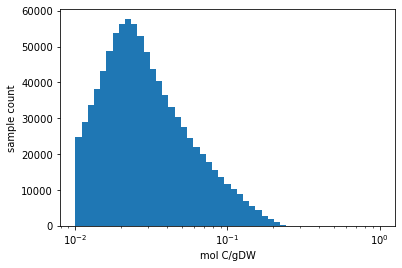

In [50]:
# protein density ≈250 mg/mL = 250 g/L
# ^^^ considering only the cells not the media
protein_density_range = (200,300)  # g/L

# Cell size range, see
# http://book.bionumbers.org/how-big-is-an-e-coli-cell-and-what-is-its-mass/
v_cell_range = (0.5e-15, 2e-15)    # L

# usage-weighted amino acid MW ≈110 g/mol, 5 carbons. 
# see calculation above. Giving ranges around those numbers.
aa_molar_mass_range = (100, 130)   # g/mol/aa
nc_per_aa_range = (4.8, 5.2)       # C atoms/aa

# E. coli cell has a typical mass of a few hundred femtograms 
# http://book.bionumbers.org/how-big-is-an-e-coli-cell-and-what-is-its-mass/
m_cell_range = (1e-13, 1e-12)         # g/cell

# Monte-Carlo sampling of the slope
vals = protein_C_per_gDW_range(
    protein_density_range,
    v_cell_range,
    m_cell_range,
    aa_molar_mass_range,
    nc_per_aa_range, 
    n_samples=int(1e6))


pctiles = [2.5, 25, 50, 75, 97.5]
pctile_vals = np.percentile(vals, pctiles)
print('median {0:.2g}'.format(pctile_vals[2]))

print('geometric mean {0:.2g}'.format(gmean(vals)))
print('95% CI {0:.2g}-{1:.2g}'.format(pctile_vals[0],pctile_vals[-1]))
print('IQR {0:.2g}-{1:.2g}'.format(pctile_vals[1],pctile_vals[-2]))

# For later use - present the IQR
protein_C_per_gDW_IQR = pctile_vals[[1,-2]].copy()
protein_C_per_gDW_median = pctile_vals[2]

plt.figure()
plt.xscale('log')
plt.hist(vals, np.logspace(-2, 0, 50))
plt.xlabel('mol C/gDW')
plt.ylabel('sample count')
plt.show()

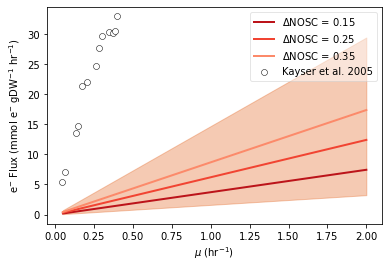

In [81]:
# Growth rates u range from 0.05 (10 hrs) to 2 (20 min)
growth_rates = np.arange(0.05, 2.01, 0.05)

# Assume proteins are produced to match dilution by growth, i.e. degradation is negligible
# as typical lifetimes are longer than generation times. This is more likely to be true
# at higher growth rates.
protein_C_flux_med = 1e3*protein_C_per_gDW_median * growth_rates    # mmol aa C / gDW / hr
protein_C_flux_min = 1e3*protein_C_per_gDW_IQR[0] * growth_rates    # mmol aa C / gDW / hr
protein_C_flux_max = 1e3*protein_C_per_gDW_IQR[1] * growth_rates    # mmol aa C / gDW / hr

min_delta_NOSC = 0.1
protein_e_flux_min = protein_C_flux_min * min_delta_NOSC
max_delta_NOSC = 0.35
protein_e_flux_max = protein_C_flux_max * max_delta_NOSC

oranges = sns.color_palette('Oranges')
plt.fill_between(growth_rates, protein_e_flux_min, protein_e_flux_max,
                 color=oranges[-2], alpha=0.3)

pal = sns.color_palette('Reds_r', n_colors=4)
for i, delta_nos in enumerate(np.arange(0.15, 0.36, 0.1)):
    # delta nos is e- per protein-bound carbon atom
    protein_e_flux = delta_nos * protein_C_flux_med
    label = '$\Delta$NOSC = {0:0.2f}'.format(delta_nos)
    plt.plot(growth_rates, protein_e_flux, label=label, color=pal[i], lw=2)
    
r_o2_mmol_e_g_h = 1e3*e_per_o2*chemostat_df.r_o2_g_g_h/mw_o2
plt.scatter(chemostat_df.D_per_h, r_o2_mmol_e_g_h,
            label='Kayser et al. 2005',
            color='w', edgecolors='k', lw=0.5, marker='o')

plt.ylabel('e$^{-}$ Flux (mmol e$^{-}$ gDW$^{-1}$ hr$^{-1}$)')
plt.xlabel('$\mu$ (hr$^{-1}$)')

plt.legend(loc=1, framealpha=0.5)
plt.savefig('../output/proteome_electron_flux_estimate.png')
plt.show() 